(https://upload.wikimedia.org/wikipedia/commons/thumb/4/42/Cassandra1.jpeg/800px-Cassandra1.jpeg)
## Notebook to run serial methods

With this notebook you can run live/backtest Kaissandra, plot live results and much more

In [39]:
import sys
import os

this_path = os.getcwd()
path = '\\'.join(this_path.split('\\')[:-1])+'\\'
if path not in sys.path:
    sys.path.insert(0, path)
    print(path+" added to python path")
else:
    print(path+" already in python path")
    
import pandas as pd
import datetime as dt
import pickle
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2


C:\Users\mgutierrez\root\Projects\SDC\py\kaissandra\ already in python path
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Init Util Functions and Constants 

In [2]:
def get_positions_filename(asset, open_dt, close_dt):
    """  """
    
    dt_open = dt.datetime.strftime(dt.datetime.strptime(
            open_dt,'%Y.%m.%d %H:%M:%S'),'%y%m%d%H%M%S')
    dt_close = dt.datetime.strftime(dt.datetime.strptime(
            close_dt,'%Y.%m.%d %H:%M:%S'),'%y%m%d%H%M%S')
    filename = 'O'+dt_open+'C'+dt_close+asset
    return filename

In [3]:
live = True

if live:
    ext = '_LI_'
    directory = 'kaissandra_live/live'
    start_time = '19_01_27_23_18_41'
else:
    ext = '_BT_'
    directory = 'back_test'
    start_time = '19_01_27_16_04_55'
results_dir = '../../RNN/resultsLive/'+directory+'/trader/'
positions_dir = '../../RNN/resultsLive/'+directory+'/positions/'+start_time+'/'
filename = results_dir+start_time+ext+"positions_soll.log"
positions = pd.read_csv(filename).sort_values(by=['Entry Time']).reset_index().drop(labels='index',axis=1)
print(positions.to_string())

    Asset           Entry Time            Exit Time  Position         Bi         Ai         Bo         Ao  ticks_d      GROI    Spread       ROI     Profit  E_spread  stoploss    stGROI     stROI
0  EURUSD  2019.01.29 02:23:21  2019.01.29 02:50:01         1    1.14272    1.14279    1.14282    1.14289        0  0.008751  0.006125  0.002625   0.262515  0.006127         2  0.008751  0.002625
1  GBPUSD  2019.01.29 15:44:10  2019.01.29 15:47:41         2    1.31906    1.31917    1.31771    1.31781        0 -0.103095  0.007581 -0.110676 -11.067565  0.008339         2 -0.103095 -0.110676
2  EURGBP  2019.01.29 19:56:32  2019.01.29 20:03:09         2    0.86936    0.86946    0.86974    0.86988        0  0.048306  0.016102  0.032204   3.220390  0.011501         2  0.048306  0.032204
3  EURGBP  2019.01.29 21:55:50  2019.01.29 22:01:04        -2    0.87214    0.87229    0.87251    0.87266        0 -0.042399  0.017189 -0.059588  -5.958793  0.016041         2  0.005907 -0.027384
4  EURGBP  2019.01.2

## Build Stats File and Plot Positions

C:\ProgramData\Anaconda3\envs\py35\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


{'id': 0, 'dts': ['2019.01.29 22:05:17', '2019.01.29 22:05:17', '2019.01.29 22:05:20', '2019.01.29 22:05:20', '2019.01.29 22:05:30', '2019.01.29 22:05:39', '2019.01.29 22:05:43', '2019.01.29 22:05:49', '2019.01.29 22:06:01', '2019.01.29 22:06:09', '2019.01.29 22:10:52'], 'levels': [-2, -2, -2, -2, -2, -2, -2, -2, -2, -2, None], 'strategy': ['15e_1t_77m_2p', '22e_0t_57m_1p', '15e_1t_77m_2p', '22e_0t_57m_1p', '22e_0t_57m_1p', '22e_0t_57m_1p', '22e_0t_57m_1p', '22e_0t_57m_1p', '22e_0t_57m_1p', '22e_0t_57m_1p', None], 'grois': [0.0, 0.0, -0.00018294077292482162, -0.00018294077292482162, -0.00019438790678541235, -8.004940191675493e-05, -9.148084619791881e-05, -6.861455772206531e-05, 1.1436675129754214e-05, 3.4310810192441865e-05, 0.0003775527715805062], '@tick#': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 120], 'p_mcs': [0.8578566908836365, 0.8578566908836365, 0.8578566908836365, 0.8578566908836365, 0.8578566908836365, 0.8578566908836365, 0.8578566908836365, 0.8578566908836365, 0.8578566908836365, 0.85

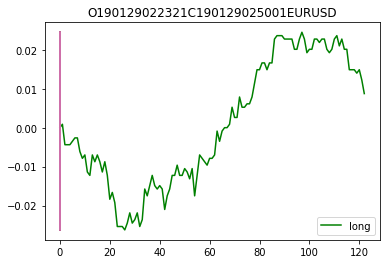

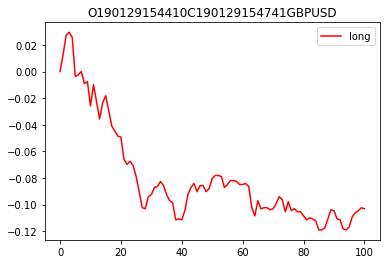

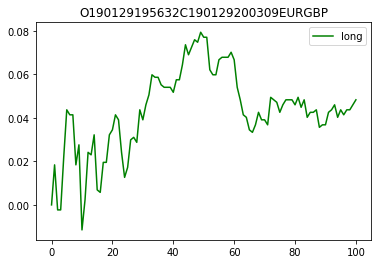

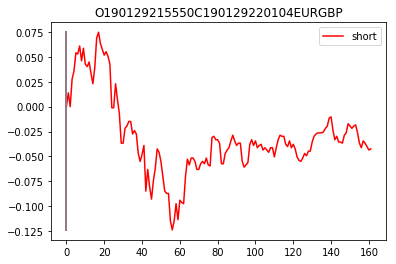

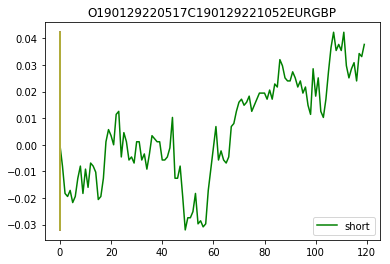

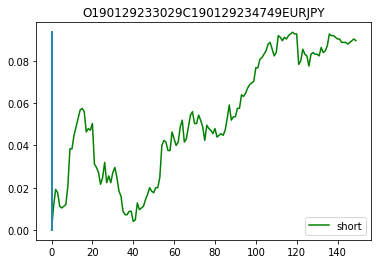

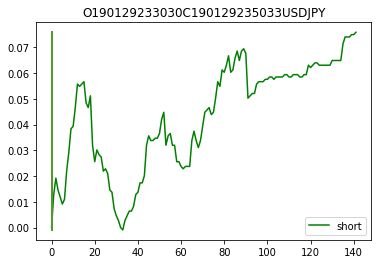

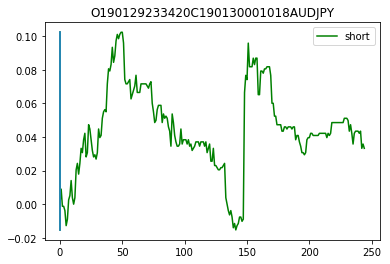

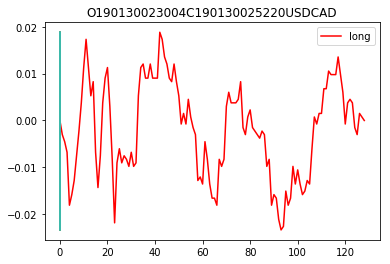

In [6]:
columns = ['asset','Di','Ti','Do','To','direction','groi','roi','profit','e_spread','spread','max','min','argmax','argmin','samples','extensions','stoploss','file']
pos_format = pd.DataFrame(data=0,columns=columns,index=range(positions.shape[0]))
plt_index = 0
for p in range(positions.shape[0]):
    #print(positions.iloc[p])
    pos_format['asset'].iloc[p] = positions['Asset'].iloc[p]
    pos_format['Di'].iloc[p] = positions['Entry Time'].iloc[p][:10]
    pos_format['Ti'].iloc[p] = positions['Entry Time'].iloc[p][11:]
    pos_format['Do'].iloc[p] = positions['Exit Time'].iloc[p][:10]
    pos_format['To'].iloc[p] = positions['Exit Time'].iloc[p][11:]
    pos_format['groi'].iloc[p] = positions['GROI'].iloc[p]
    pos_format['roi'].iloc[p] = positions['ROI'].iloc[p]
    pos_format['e_spread'].iloc[p] = positions['E_spread'].iloc[p]
    pos_format['spread'].iloc[p] = positions['Spread'].iloc[p]
    pos_format['profit'].iloc[p] = positions['Profit'].iloc[p]
    pos_format['stoploss'].iloc[p] = positions['stoploss'].iloc[p]
    direction = positions['Position'].iloc[p]
    pos_format['direction'].iloc[p] = direction
    filename_pos = get_positions_filename(positions['Asset'].iloc[p], positions['Entry Time'].iloc[p], positions['Exit Time'].iloc[p])
    pos_format['file'].iloc[p] = filename_pos
    pos_ev = pd.read_csv(positions_dir+filename_pos+'.txt', sep=',')
    pos_track = pickle.load( open( positions_dir+filename_pos+".p", "rb" ))
    if p==4:
        print(pos_track)
    pos_format['extensions'].iloc[p] = pos_track['n_ext']
    pos_format['samples'].iloc[p] = pos_ev.shape[0]
    #print(pos_ev.columns)
    maxBid = pos_ev['SymbolBid'].max()
    minBid = pos_ev['SymbolBid'].min()
    maxAsk = pos_ev['SymbolAsk'].max()
    minAsk = pos_ev['SymbolAsk'].min()
    Bi = positions['Bi'].iloc[p]
    Ai = positions['Ai'].iloc[p]
    #if direction>0:
    #        GROI_live = roi_ratio*(Ao-Ai)/Ai
    #        spread = (Ao-Bo)/Ai
    #        
    #    else:
    #        GROI_live = roi_ratio*(Bi-Bo)/Ao
    if direction>0:
        pos_format['max'].iloc[p] = 100*(maxAsk-positions['Ai'].iloc[p])/positions['Ai'].iloc[p]
        pos_format['min'].iloc[p] = 100*(minAsk-positions['Ai'].iloc[p])/positions['Ai'].iloc[p]
        pos_format['argmax'].iloc[p] = pos_ev['SymbolAsk'].idxmax()
        pos_format['argmin'].iloc[p] = pos_ev['SymbolAsk'].idxmin()
        groi_ev = 100*(pos_ev['SymbolAsk'].iloc[:]-positions['Ai'].iloc[p])/positions['Ai'].iloc[p]
        label = 'long'
    else:
        pos_format['max'].iloc[p] = 100*(positions['Bi'].iloc[p]-minBid)/maxAsk
        pos_format['min'].iloc[p] = 100*(positions['Bi'].iloc[p]-maxBid)/maxAsk
        pos_format['argmax'].iloc[p] = pos_ev['SymbolBid'].idxmax()
        pos_format['argmin'].iloc[p] = pos_ev['SymbolBid'].idxmin()
        groi_ev = 100*(positions['Bi'].iloc[p]-pos_ev['SymbolBid'].iloc[:])/pos_ev['SymbolAsk'].iloc[:]
        label = 'short'
    if positions['GROI'].iloc[p]>0:
        color = 'green'
    else:
        color = 'red'
    plt.figure(plt_index)
    plt.plot(groi_ev, color=color, label=label)
    for e in range(pos_track['n_ext']):
        plt.plot([pos_track['@tick#'][e+1] for i in range(2)],[pos_format['min'].iloc[p], pos_format['max'].iloc[p]])
    plt.legend()
    plt.title(filename_pos)
    plt_index += 1
print(pos_format.to_string())
pos_format.to_csv(positions_dir+'stats.csv', index=False, sep='\t', float_format='%.5f')
print("Positions summary saved")

## Get Summary from Position Stats

In [5]:
tgroi = pos_format['groi'].sum()
troi = pos_format['roi'].sum()
tprofit = pos_format['profit'].sum()
mspread = pos_format['spread'].mean()
emspread = pos_format['e_spread'].mean()
SIs = pos_format.agg({'groi': lambda x: 100*np.sum(x>0)/len(x),
                      'roi': lambda x: 100*np.sum(x>0)/len(x)})
av_win = sum(pos_format[pos_format['groi']>0]['groi'])/len(pos_format[pos_format['groi']>0]['groi'])
av_lose = sum(pos_format[pos_format['groi']<0]['groi'])/len(pos_format[pos_format['groi']<0]['groi'])
per_under_2p = 100*pos_format[pos_format['e_spread']<0.02].shape[0]/pos_format.shape[0]

print("Total GROI = {0:.2f}% ".format(tgroi)+"Total ROI = {0:.2f}% ".format(troi)+"total profit = {0:.2f}e ".format(tprofit)+"mean spread = {0:.2f} pips ".format(100*mspread)+
      "expected mean spread = {0:.2f} pips ".format(100*emspread))
print("Number entries "+str(pos_format.shape[0])+" GSP = {0:.2f}% ".format(SIs['groi'])+" NSP = {0:.2f}% ".format(SIs['roi'])+" av win = {0:.3f}% ".format(av_win)+" av lose = {0:.3f}% ".format(av_lose))
print("Percent below 2p {0:.2f}%".format(per_under_2p))
#print(pd.DataFrame(prob_rois))
grouped = pos_format.groupby(['asset'])
#print(grouped.get_group(('GBPJPY',1)).to_string())
#grouped.aggregate(np.sum)
#grouped['groi'].describe()
#grouped.get_group('GBPJPY')
SI = grouped.agg({'groi': lambda x: np.sum(x>0)/len(x),
             'roi': lambda x: np.sum(x>0)/len(x)})#.rename(['GSI','NSI'])
grouped.agg({'e_spread': lambda x: 100*np.sum(x<0.02)/len(x)})
#print(SI)
#print(grouped.describe())
#for name, group in grouped:
    #print(name)
#    print(group.to_string())

Total GROI = 0.15% Total ROI = -0.01% total profit = -0.55e mean spread = 1.71 pips expected mean spread = 1.43 pips 
Number entries 9 GSP = 66.67%  NSP = 55.56%  av win = 0.049%  av lose = -0.073% 
Percent below 2p 88.89%


,e_spread
asset,
AUDJPY,0.0
EURGBP,100.0
EURJPY,100.0
EURUSD,100.0
GBPUSD,100.0
USDCAD,100.0
USDJPY,100.0


## Run KaissandOnline

In [ ]:
from kaissandra.runLive import launch
launch()

Config file ../../config/T0003.config loaded from disk
../../RNN/IOlive/AUDCAD/ Directiory renewed
C:/Users/mgutierrez/AppData/Roaming/MetaQuotes/Terminal/D0E8209F77C8CF37AD8BF550E51FF075/MQL5/Files/IOlive/AUDCAD/ Directiory created
../../RNN/IOlive/AUDCAD/ Directiory created
../../RNN/IOlive/EURAUD/ Directiory renewed
C:/Users/mgutierrez/AppData/Roaming/MetaQuotes/Terminal/D0E8209F77C8CF37AD8BF550E51FF075/MQL5/Files/IOlive/EURAUD/ Directiory created
../../RNN/IOlive/EURAUD/ Directiory created
../../RNN/IOlive/EURCAD/ Directiory renewed
C:/Users/mgutierrez/AppData/Roaming/MetaQuotes/Terminal/D0E8209F77C8CF37AD8BF550E51FF075/MQL5/Files/IOlive/EURCAD/ Directiory created
../../RNN/IOlive/EURCAD/ Directiory created
../../RNN/IOlive/EURCHF/ Directiory renewed
C:/Users/mgutierrez/AppData/Roaming/MetaQuotes/Terminal/D0E8209F77C8CF37AD8BF550E51FF075/MQL5/Files/IOlive/EURCHF/ Directiory created
../../RNN/IOlive/EURCHF/ Directiory created
../../RNN/IOlive/EURGBP/ Directiory renewed
C:/Users/mgut

In [42]:
import kaissandra.control as ct
ct.pause()

EURCAD
EURCZK
Asset not running
[USDX]
Asset not running
EURJPY
NZDUSD
EURCHF
AUDCAD
USDHKD
Asset not running
USDMXN
Asset not running
CHFJPY
EURPLN
Asset not running
XAUUSD
Asset not running
EURUSD
EURNZD
USDJPY
GBPCHF
GBPAUD
USDPLN
Asset not running
GBPUSD
USDCHF
XAGUSD
Asset not running
USDCAD
EURDKK
Asset not running
EURGBP
EURAUD
USDRUB
Asset not running
USDSGD
Asset not running
AUDJPY
USDNOK
Asset not running
CADJPY
GBPCAD
GBPJPY
GOLD
Asset not running


In [43]:
import kaissandra.control as ct
ct.resume()

EURCAD
EURCZK
FileNotFoundError
[USDX]
FileNotFoundError
EURJPY
NZDUSD
EURCHF
AUDCAD
USDHKD
FileNotFoundError
USDMXN
FileNotFoundError
CHFJPY
EURPLN
FileNotFoundError
XAUUSD
FileNotFoundError
EURUSD
EURNZD
USDJPY
GBPCHF
GBPAUD
USDPLN
FileNotFoundError
GBPUSD
USDCHF
XAGUSD
FileNotFoundError
USDCAD
EURDKK
FileNotFoundError
EURGBP
EURAUD
USDRUB
FileNotFoundError
USDSGD
FileNotFoundError
AUDJPY
USDNOK
FileNotFoundError
CADJPY
GBPCAD
GBPJPY
GOLD
FileNotFoundError


In [44]:
import kaissandra.control as ct
ct.shutdown()

EURCAD
EURCZK
FileNotFoundError
[USDX]
FileNotFoundError
EURJPY
NZDUSD
EURCHF
AUDCAD
USDHKD
FileNotFoundError
USDMXN
FileNotFoundError
CHFJPY
EURPLN
FileNotFoundError
XAUUSD
FileNotFoundError
EURUSD
EURNZD
USDJPY
GBPCHF
GBPAUD
USDPLN
FileNotFoundError
GBPUSD
USDCHF
XAGUSD
FileNotFoundError
USDCAD
EURDKK
FileNotFoundError
EURGBP
EURAUD
USDRUB
FileNotFoundError
USDSGD
FileNotFoundError
AUDJPY
USDNOK
FileNotFoundError
CADJPY
GBPCAD
GBPJPY
GOLD
FileNotFoundError


In [4]:
# runLive in multiple processes
from multiprocessing import Process
import datetime as dt
import time
%load_ext autoreload
%autoreload 2

from kaissandra.runLive import run

assets = [1, 2, 3, 4, 7, 8, 10, 11, 12, 13, 14, 16, 17, 19, 27, 28, 29, 30, 31, 32]#
running_assets = assets#[7, 14]
start_time = dt.datetime.strftime(dt.datetime.now(),'%y_%m_%d_%H_%M_%S')
#disp = Process(target=run, args=[running_assets,start_time])
#disp.start()
for ass_idx in range(len(running_assets)):
    disp = Process(target=run, args=[running_assets[ass_idx:ass_idx+1],start_time])
    disp.start()
    time.sleep(2)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Get total returns

In [ ]:
import pandas as pd
start_time = '18_12_10_10_53_20'
results_dir = '../RNN/resultsLive/back_test/trader/'
filename = results_dir+start_time+'_LI_'+"positions_soll.log"
positions = pd.read_csv(filename)
print(positions.GROI.sum())
print(positions.ROI.sum())
print(positions.Profit.sum())
print(positions.Profit)

## Retrieve Positions from Trader Simulation

In [1]:
# Positions file from trader simulation
pos_dirname = '../../RNN/resultsLive/simulate/trader/positions/'
numberNetwors = 3
start_time = '190212144049'
list_IDresults = ['100350NJLS','100327S','100500L']#
list_IDgre = [None for i in range(numberNetwors)]
list_name = ['100350NJLS_13_3_.65_.6','100327S_21_0_.75_.7','100500L_29_3_.7_.6']
list_epoch_gre = [None for i in range(numberNetwors)]
list_epoch_journal = [13,21,29]
list_t_index = [3,0,2]
list_spread_ranges = [{'sp':[2.5],'th':[(.65,.6)]},{'sp':[2.5],'th':[(.75,.7)]},{'sp':[2.5],'th':[(.7,.6)]}]
pos_filename = start_time+'_'+'_'.join([list_IDresults[i]+'E'+str(list_epoch_journal[i])+'TI'+
                         str(list_t_index[i])+'MC'+str(list_spread_ranges[i]['th'][0][0])+'MD'+
                         str(list_spread_ranges[i]['th'][0][1])
                         for i in range(numberNetwors)])
print(pos_filename)


190212144049_100350NJLSE13TI3MC0.65MD0.6_100327SE21TI0MC0.75MD0.7_100500LE29TI2MC0.7MD0.6


In [7]:
# Positions file from trader simulation
pos_dirname = '../../RNN/resultsLive/simulate/trader/positions/'
numberNetwors = 2
start_time = '190213090034'
list_IDresults = ['100327S','100500L']#
list_IDgre = [None for i in range(numberNetwors)]
list_name = ['100327S_21_0_.75_.7','100500L_29_3_.7_.6']
list_epoch_gre = [None for i in range(numberNetwors)]
list_epoch_journal = [21,29]
list_t_index = [0,2]
list_spread_ranges = [{'sp':[2.5],'th':[(.75,.7)]},{'sp':[2.5],'th':[(.7,.6)]}]
pos_filename = start_time+'_'+'_'.join([list_IDresults[i]+'E'+str(list_epoch_journal[i])+'TI'+
                         str(list_t_index[i])+'MC'+str(list_spread_ranges[i]['th'][0][0])+'MD'+
                         str(list_spread_ranges[i]['th'][0][1])
                         for i in range(numberNetwors)])
print(pos_filename)


190213090034_100327SE21TI0MC0.75MD0.7_100500LE29TI2MC0.7MD0.6


In [12]:
# Positions file from trader simulation
pos_dirname = '../../RNN/resultsLive/simulate/trader/positions/'
numberNetwors = 1
start_time = '190213095021'
#E13TI3MC0.65MD0.6
list_IDresults = ['100350NJLS']#
list_IDgre = [None for i in range(numberNetwors)]
#list_name = ['100327S_21_0_.75_.7','100500L_29_3_.7_.6']
list_epoch_gre = [None for i in range(numberNetwors)]
list_epoch_journal = [13]
list_t_index = [3]
list_spread_ranges = [{'sp':[2.5],'th':[(.65,.6)]}]
pos_filename = start_time+'_'+'_'.join([list_IDresults[i]+'E'+str(list_epoch_journal[i])+'TI'+
                         str(list_t_index[i])+'MC'+str(list_spread_ranges[i]['th'][0][0])+'MD'+
                         str(list_spread_ranges[i]['th'][0][1])
                         for i in range(numberNetwors)])
print(pos_filename)


190213095021_100350NJLSE13TI3MC0.65MD0.6


In [28]:

pos_dirname = '../../RNN/resultsLive/simulate/trader/positions/'
numberNetwors = 2
start_time = '190213103037'
#E13TI3MC0.65MD0.6
list_IDresults = ['100350S','100350L']#
list_IDgre = [None for i in range(numberNetwors)]
#list_name = ['100327S_21_0_.75_.7','100500L_29_3_.7_.6']
list_epoch_gre = [None for i in range(numberNetwors)]
list_epoch_journal = [13,6]
list_t_index = [3,1]
list_spread_ranges = [{'sp':[2.5],'th':[(.55,.6)]},{'sp':[2.5],'th':[(.65,.65)]}]
pos_filename = start_time+'_'+'_'.join([list_IDresults[i]+'E'+str(list_epoch_journal[i])+'TI'+
                         str(list_t_index[i])+'MC'+str(list_spread_ranges[i]['th'][0][0])+'MD'+
                         str(list_spread_ranges[i]['th'][0][1])
                         for i in range(numberNetwors)])
print(pos_filename)

190213103037_100350SE13TI3MC0.55MD0.6_100350LE6TI1MC0.65MD0.65


In [32]:
numberNetwors = 4
start_time = '190213121736'
#E13TI3MC0.65MD0.6
list_IDresults = ['100350S','100350L']+['100327S','100500L']#
list_IDgre = [None for i in range(numberNetwors)]
#list_name = ['100327S_21_0_.75_.7','100500L_29_3_.7_.6']
list_epoch_gre = [None for i in range(numberNetwors)]
list_epoch_journal = [13,6]+[21,29]
list_t_index = [3,1]+[0,2]
list_spread_ranges = [{'sp':[2.5],'th':[(.55,.6)]},{'sp':[2.5],'th':[(.65,.65)]}]+[{'sp':[2.5],'th':[(.75,.7)]},{'sp':[2.5],'th':[(.7,.6)]}]
pos_filename = start_time+'_'+'_'.join([list_IDresults[i]+'E'+str(list_epoch_journal[i])+'TI'+
                         str(list_t_index[i])+'MC'+str(list_spread_ranges[i]['th'][0][0])+'MD'+
                         str(list_spread_ranges[i]['th'][0][1])
                         for i in range(numberNetwors)])
print(pos_filename)

190213121736_100350SE13TI3MC0.55MD0.6_100350LE6TI1MC0.65MD0.65_100327SE21TI0MC0.75MD0.7_100500LE29TI2MC0.7MD0.6


In [33]:
import pandas as pd

positions = pd.read_csv(pos_dirname+pos_filename+'.csv',sep='\t')
#print(positions)
pip_limit = 0.025
pos_under_2p = positions['espread']<pip_limit
positions['DTo'] = positions["Do"] + " "+ positions["To"]
pos_under_thr = positions[pos_under_2p]#.sort_values(by=['DTo'])
per_under_2p = 100*sum(pos_under_2p)/positions.shape[0]
tgsr = 100*sum(positions['GROI']>0)/positions.shape[0]
gsr = 100*sum(pos_under_thr['GROI']>0)/sum(pos_under_2p)
tsr = 100*sum(positions['ROI']>0)/positions.shape[0]
sr = 100*sum(positions[pos_under_2p]['ROI']>0)/sum(pos_under_2p)
mean_spread = positions[pos_under_2p]['spread'].mean()
print("total mean GROI")
print(positions['GROI'].mean())
print("mean GROI of selected")
print(positions[pos_under_2p]['GROI'].mean())
print("mean_spread of selected")
print(mean_spread)
print("Number of pos under "+str(pip_limit))
print(positions[pos_under_2p].shape[0])
print("per under pip_limit")
print(per_under_2p)
print("total gross success rate")
print(tgsr)
print("gross success rate")
print(gsr)
print("total success rate")
print(tsr)
print("success rate")
print(sr)
print("GROI for positions under "+str(pip_limit))
print(positions[pos_under_2p]['GROI'].sum())
print("ROI for positions under "+str(pip_limit))
print(positions[pos_under_2p]['ROI'].sum())
print("positions['GROI'].sum()-pip_limit*positions['GROI'].shape[0]")
print(positions['GROI'].sum()-pip_limit*positions['GROI'].shape[0])
print("# Assets")
print(positions['Asset'][pos_under_2p].unique().shape[0])
pos_under_thr.to_csv(pos_dirname+pos_filename+str(100*pip_limit)+'pFilt.csv', index=False, sep='\t')

total mean GROI
0.03938055953427978
mean GROI of selected
0.03938055953427978
mean_spread of selected
0.015472610906212323
Number of pos under 0.025
827
per under pip_limit
100.0
total gross success rate
61.668681983071345
gross success rate
61.668681983071345
total success rate
57.194679564691654
success rate
57.194679564691654
GROI for positions under 0.025
32.5677227348494
ROI for positions under 0.025
19.771873515411812
positions['GROI'].sum()-pip_limit*positions['GROI'].shape[0]
11.892722734849396
# Assets
21


In [23]:
positions

,Asset,Di,Ti,Do,To,GROI,ROI,spread,espread,ext,Dir,Bi,Bo,Ai,Ao,DTo
0,EURCAD,2018.03.13,16:33:40,2018.03.13,16:58:46,-0.046931,-0.070083,0.023152,0.021912,0,-1,1.59698,1.59773,1.59733,1.59810,2018.03.13 16:58:46
1,USDCAD,2018.03.13,16:31:05,2018.03.13,16:59:34,0.128524,0.119233,0.009291,0.010052,0,-1,1.29313,1.29147,1.29326,1.29159,2018.03.13 16:59:34
2,EURCAD,2018.03.13,17:23:59,2018.03.13,17:50:10,-0.016237,-0.038720,0.022483,0.023111,0,-1,1.60062,1.60088,1.60099,1.60124,2018.03.13 17:50:10
3,GBPJPY,2018.03.19,12:31:14,2018.03.19,12:51:18,-0.237560,-0.259705,0.022145,0.023543,0,-1,148.62800,148.98200,148.66300,149.01500,2018.03.19 12:51:18
4,AUDJPY,2018.03.19,12:33:09,2018.03.19,13:15:15,0.138226,0.116208,0.022018,0.021988,0,-1,81.84500,81.73200,81.86300,81.75000,2018.03.19 13:15:15
5,EURJPY,2018.03.19,12:52:29,2018.03.19,13:29:04,0.134284,0.121239,0.013045,0.013027,0,-1,130.47900,130.30400,130.49600,130.32100,2018.03.19 13:29:04
6,GBPJPY,2018.03.19,14:05:34,2018.03.19,14:22:35,-0.064866,-0.086266,0.021399,0.022751,0,-1,149.40900,149.50600,149.44300,149.53800,2018.03.19 14:22:35
7,EURJPY,2018.03.19,14:15:50,2018.03.19,14:39:49,-0.025989,-0.038984,0.012995,0.012998,0,-1,130.77200,130.80600,130.78900,130.82300,2018.03.19 14:39:49
8,AUDJPY,2018.03.19,21:20:45,2018.03.19,22:04:31,0.084267,0.059841,0.024425,0.021965,0,-1,81.93200,81.86300,81.95000,81.88300,2018.03.19 22:04:31
9,AUDCAD,2018.03.21,14:06:21,2018.03.21,14:53:09,-0.034063,-0.056104,0.022041,0.024045,0,1,0.99790,0.99758,0.99814,0.99780,2018.03.21 14:53:09


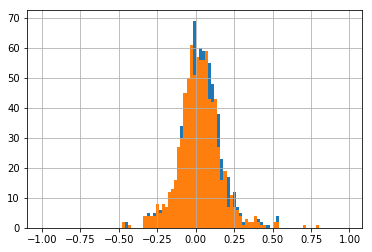

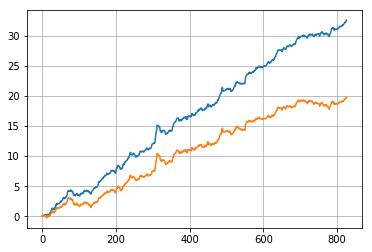

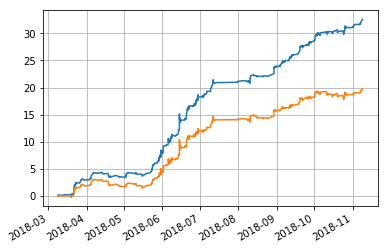

In [34]:
import matplotlib
import matplotlib.pyplot as plt
import datetime as dt

plt.figure(0)
bins = [i/100 for i in range(-100,100,2)]
histG = plt.hist(pos_under_thr['GROI'], bins=bins)
histR = plt.hist(pos_under_thr['ROI'], bins=bins)
plt.grid()

#pos_under_thr.index = range(pos_under_thr.shape[0])
plt.figure(1)
plt.plot(range(pos_under_thr.shape[0]),pos_under_thr['GROI'].cumsum())
plt.plot(range(pos_under_thr.shape[0]),pos_under_thr['ROI'].cumsum())
plt.grid()

list_dates = [dt.datetime.strptime(date, '%Y.%m.%d %H:%M:%S') for date in positions['DTo']]
dates = matplotlib.dates.date2num(list_dates)
plt.figure(2)
plt.plot_date(list_dates, pos_under_thr['GROI'].cumsum(),fmt='-')
plt.plot_date(list_dates, pos_under_thr['ROI'].cumsum(),fmt='-')
plt.gcf().autofmt_xdate()
plt.grid()

Asset
AUDCAD    0.542359
AUDJPY    4.152853
CADJPY    0.115273
CHFJPY    0.067865
EURAUD   -0.192700
EURCAD    0.974623
EURCHF   -0.121282
EURGBP    0.617676
EURJPY    1.537915
EURNZD    1.112103
EURUSD    1.527521
GBPAUD    1.596829
GBPCAD    1.356418
GBPCHF    0.236248
GBPJPY    0.958917
GBPUSD    1.845176
GOLD      1.367162
NZDUSD    1.098908
USDCAD    0.587564
USDCHF    0.573920
USDJPY   -0.183477
Name: ROI, dtype: float64


AttributeError: 'Figure' object has no attribute 'autofmt'

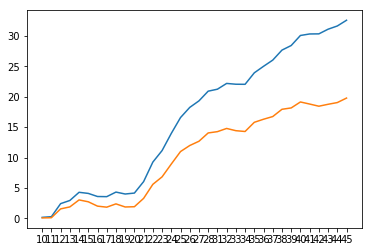

In [37]:
#positions
#grouped = pos_format.groupby(['asset'])
weekly_group = pos_under_thr.groupby([pd.to_datetime(pos_under_thr['Di']).dt.strftime('%W')])['ROI']
weekly_group_G = pos_under_thr.groupby([pd.to_datetime(pos_under_thr['Di']).dt.strftime('%W')])['GROI']
asset_group = pos_under_thr.groupby(['Asset'])
weekly_sum = weekly_group.sum()
weekly_sum_G = weekly_group_G.sum()
weekly_count = weekly_group.count()
#weekly_sum.cumsum()
#print(asset_group['GROI'].sum())
print(asset_group['ROI'].sum())
plt.figure(0)
plt.plot(weekly_sum_G.cumsum())
plt.plot(range(weekly_sum.shape[0]), weekly_sum.cumsum())
plt.gcf().autofmt_xdate()
plt.grid()
print(weekly_sum_G)
print(weekly_sum)#.cumsum()
print(weekly_count)
print(weekly_sum.cumsum())
print(weekly_count.shape)
#print(pos_under_thr.groupby([pd.to_datetime(pos_under_thr['Di']).dt.strftime('%W')])['GROI'].sum())
#print(weekly_count)
plt.figure(1)
plt.grid()
plt.hist(weekly_count, bins=range(0,max(weekly_count),5))

#for name, group in asset_group:
#    print(name)
#    print(group.to_string())
#pd.to_datetime(positions['Di']).dt.strftime('%W')
#pd.to_datetime(positions['Di'])#.groupby('Name').resample('W-Mon', on='Date').sum().reset_index().sort_values(by='Date')